In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
df = pd.read_csv('superstoredata.csv', sep=',')

In [4]:
df.shape

(541909, 9)

In [5]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
Sales          float64
dtype: object

In [6]:
# Приводим столбец с датой к соответствующему типу
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
# Проверяем наличие пустых значений
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Sales               0
dtype: int64

In [8]:
df[df['CustomerID'].isna() == True]['Sales'].unique()

array([   0.  ,    2.51,    5.02, ...,  438.24,  270.6 , 1714.17])

In [9]:
# Удаляем пустые значения
df = df.dropna(subset=['CustomerID'])

In [99]:
df.shape

(406829, 9)

In [10]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Sales          0
dtype: int64

In [11]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


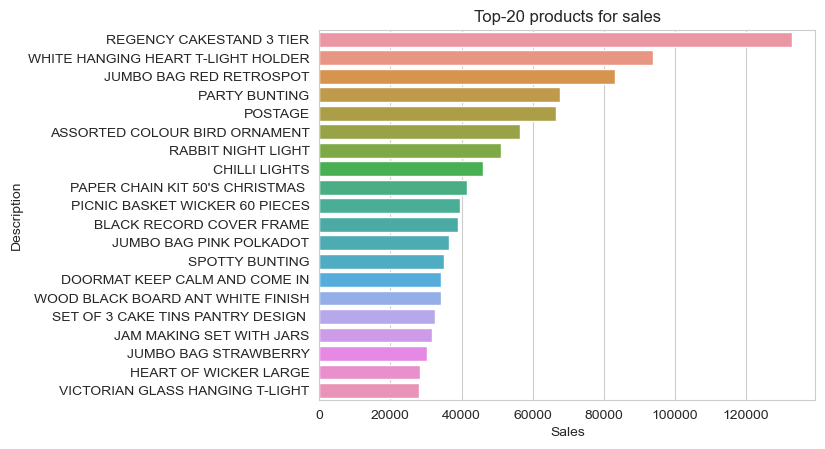

In [12]:
# Определим топ-20 товаров по продажам
top_20_sales = df.groupby('Description') \
                 .agg({'Sales':'sum'}) \
                 .sort_values(by='Sales', ascending=False) \
                 .reset_index() \
                 .nlargest(n=20, columns='Sales', keep='all')

sns.set_style("whitegrid")
ax = sns.barplot(data=top_20_sales, y='Description', x='Sales')
plt.title('Top-20 products for sales');

### RFM - анализ

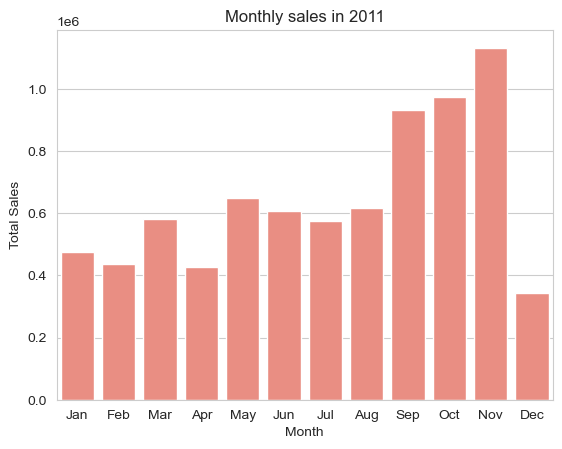

In [13]:
# Посмотрим на динамику продаж
sales_2011 = df[df['InvoiceDate'].dt.year == 2011].groupby(df['InvoiceDate'].dt.month).agg({'Sales':'sum'})

sns.barplot(data=sales_2011, y='Sales', x=sales_2011.index, color='salmon')
plt.title('Monthly sales in 2011')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(ticks=np.arange(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

Цели анализа:
1. Сегментация клиентов. Разделим клиентов на различные сегменты в зависимости от их поведения и степени активности.
2. Оптимизация маркетинговых кампаний. Подберем маркетинговые кампании/персональные предложения, направленные на различные сегменты клиентов.

In [14]:
# Посмотрим на описательные статистики числовых переменных
df.describe()

,Quantity,UnitPrice,CustomerID,Sales
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,20.401854
std,248.693370,69.315162,1713.600303,427.591718
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,2.000000,1.250000,13953.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.100000
75%,12.000000,3.750000,16791.000000,19.500000
max,80995.000000,38970.000000,18287.000000,168469.600000


Стандартное отклонение по столбцу Sales достаточно высокое (427.59), что указывает на значительный разброс значений относительно среднего значения, что может говорить о наличии выбросов или различий в объеме продаж.

Медиана(11.10) меньше среднего значения, это указывает на то, что распределение продаж, скорее всего, смещено вправо и содержит выбросы с высокими значениями.

Минимальное отрицательное значение может говорить о наличии возвратов, при этом оно является взаимоисключающем с максимальным значением.

Поэтому в виду специфики данных определим границы в датасете, чтобы исключить аномальные значения

In [15]:
# С помощью межквартильного размаха определяем границы для исключения выбросов и отрицательных значений продаж
q1 = df.Sales.quantile(0.25)
q3 = df.Sales.quantile(0.75)
iqr = q3 - q1
iqr_bottom = q1 - 0.2 * iqr
iqr_up = q3 + 0.2 * iqr

In [16]:
# Отсортируем датафрейм в соответствии с новыми границаи и посмотрим на получившиеся статистики
df_no_outliers = df[(df.Sales > iqr_bottom) & (df.Sales < iqr_up) ]
df_no_outliers.describe()

,Quantity,UnitPrice,CustomerID,Sales
count,310002.000000,310002.000000,310002.000000,310002.000000
mean,7.080016,2.663974,15340.625731,10.026826
std,8.548679,2.550343,1700.747781,6.165727
min,1.000000,0.040000,12347.000000,1.140000
25%,2.000000,1.250000,14038.000000,4.200000
50%,4.000000,1.650000,15271.000000,9.900000
75%,10.000000,3.250000,16837.000000,15.300000
max,500.000000,21.950000,18287.000000,22.500000


In [17]:
# Для анализа будет использовать данные за период 12 месяцев
min_date = max(df_no_outliers.InvoiceDate) - timedelta(days=365)

In [80]:
# Сгруппируем данные и посчитаем количество дней, прошедших с даты последней покупки
gr_df = df_no_outliers[(df_no_outliers['Sales'] > 0)&(df_no_outliers['InvoiceDate'] >= min_date)] \
                .groupby('CustomerID') \
                .agg({'Quantity':'count', 
                      'Sales':'sum', 
                      'InvoiceDate':'last'}) \
                .reset_index()

gr_df['days_since_last_purchase'] = (max(df_no_outliers.InvoiceDate) - gr_df.InvoiceDate).dt.days
gr_df

,CustomerID,Quantity,Sales,InvoiceDate,days_since_last_purchase
0,12347.0,103,1499.12,2011-12-07 15:52:00,1
1,12348.0,7,111.08,2011-04-05 10:47:00,248
2,12349.0,59,936.76,2011-11-21 09:51:00,18
3,12350.0,12,193.60,2011-02-02 16:01:00,309
4,12352.0,70,1175.64,2011-11-03 14:37:00,35
...,...,...,...,...,...
4061,18280.0,8,133.30,2011-03-07 09:52:00,277
4062,18281.0,7,80.82,2011-06-12 10:53:00,180
4063,18282.0,10,129.60,2011-12-02 11:43:00,7
4064,18283.0,611,1991.18,2011-12-06 12:02:00,3


In [81]:
# Для каждого столбца датафрейма посмотрим глазами на распределение значений по квантилям
quantiles = [round(el, 2) for el in np.arange(0.1, 1.1, 0.1)]

gr_df[['Quantity', 'Sales', 'days_since_last_purchase']].quantile(quantiles)

,Quantity,Sales,days_since_last_purchase
0.1,6.0,73.800,4.0
0.2,11.0,126.150,14.0
0.3,17.0,190.920,22.0
0.4,24.0,268.800,32.0
0.5,34.0,356.060,49.0
0.6,47.0,502.980,69.0
0.7,65.0,706.935,105.0
0.8,96.0,1048.830,172.0
0.9,164.0,1736.855,252.0
1.0,6518.0,59172.660,364.0


In [82]:
gr_df[['Quantity', 'Sales', 'days_since_last_purchase']].mean()

Quantity                     73.702164
Sales                       741.437651
days_since_last_purchase     88.098377
dtype: float64

In [83]:
# Определяем квантили, по которым будем делить клиентов на группы. В данном случае будем использовать 33% и 66%. 
# Они позволяют поделить всех клиентов на три равных группы и при этом автоматически определить границы этих групп.
quant = [0.33, 0.66]

- Recency: Из распределения видно, что 30% покупателей совершали покупку 21 и менее дней назад, то есть это постоянные посетители супермаркета, а также новые, которые были совсем недавно, и мы хотим, чтобы они вернулись вновь. Определяем эту группу как 1. Медиана (49 дней) и среднее (88 дней) - средняя категорий, то есть группа 2. И в группу 3 попадают покупатели, которые посещали магазин почти 3 месяца назад (84 дня) - это могут быть ,например, случайные посетители, которые территориально оказались впервые в этом месте, или покупатели, ушедшие к конкурентами.

- Frequency: По даным наблюдается значительное количество клиентов, совершивших разовые покупки - 19 человек в течении 24 дней. Учитывая, что компания продает, преимущественно, товары для дома, а не продукты питания, то это очень хороший показатель. Тем не менее эта все равно наименее активная аудитория, поэтому мы определяем ее к 3 группе. Клиентов, которые посетили супермаркет 57 и более раз за почти 3 месяца, я отношу к 1 группе - они являются постоянными и лояльными к компании. Медианное количество посещений - 34, это средний сегмент, группа 2.

- Monetary: В группу 1 попадают покупатели, совершившую покупку на сумму более 600 денежных единиц. Средний сегмент (или группа 2) определяется в промежутке между 215 и 600 ден. единицами. В группу 3 попадают оставшиеся клиенты, совершившие покупку на сумму менее 215 ден. ед.

Таким образом, в результате деления пользователей на 3 группы, мы получили следующие характеристики границ сегментов:
- Сегмент 1: Покупка 24 и менее дней назад (Recency), частота покупок (Frequency) 57 и более, сумма (Monetary) 599 и больше
- Сегмент 2: Покупка 84 и менее дней назад (Recency), частота покупок (Frequency) 19-56, сумма (Monetary) 215-598
- Сегмент 3: Покупка более 84 дней назад (Recency), частота покупок (Frequency) менее 19, сумма (Monetary) менее 215

In [84]:
# Функция для определения позиции относительно показателей R,F,M и квантилей
def set_score(val, var, perc33, perc66):
    if val < perc33:
        return 3 if var != 'R' else 1
    elif val < perc66:
        return 2
    else:
        return 1 if var!= 'R' else 3

In [85]:
# Разбиваем данные по группам в соответствии с выбранными персентилями
recency_quantiles = gr_df['days_since_last_purchase'].quantile(quant)
gr_df['R'] = gr_df['days_since_last_purchase'].apply(set_score, args=('R', recency_quantiles.iloc[0], recency_quantiles.iloc[1]))

frequency_quantiles = gr_df['Quantity'].quantile(quant)
gr_df['F'] = gr_df['Quantity'].apply(set_score, args=('F', frequency_quantiles.iloc[0], frequency_quantiles.iloc[1]))

monetary_quantiles = gr_df['Sales'].quantile(quant)
gr_df['M'] = gr_df['Sales'].apply(set_score, args=('M', monetary_quantiles.iloc[0], monetary_quantiles.iloc[1]))

In [86]:
# Сформируем финальные группы
gr_df['RFM'] = gr_df.apply(lambda row: f"{row['R']}{row['F']}{row['M']}", axis=1)

In [87]:
# Определим количество групп и количество клиентов в каждой из них
df2 = gr_df.groupby('RFM')['RFM'].agg({'count'}).reset_index()

In [88]:
# Добавим новый столбец с числовым типом
df2['RFM_int'] = df2['RFM'].astype(int)

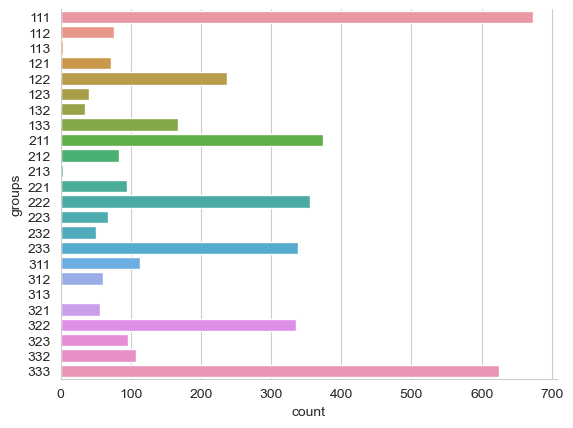

In [89]:
# Построим визуализацию получившихся групп и их значений
ax = sns.barplot(data=df2, y='RFM', x='count')
ax.set(ylabel='groups')
sns.despine()
plt.show()

Получившиеся группы можем объединить в подгруппы и определить стратегию взаимодействия для каждой из них. Таким образом, получаем следующее распределение:

In [97]:
rfm_types = {
    111: 'best_clients',
    112: 'best_clients',
    121: 'pre_best',
    113: 'potential_for_best',
    122: 'potential_for_best',
    123: 'potential_for_best',
    212: 'inactive_clients',
    213: 'inactive_clients',
    221: 'inactive_clients',
    222: 'inactive_clients',
    223: 'inactive_clients',
    232: 'inactive_clients',
    233: 'inactive_clients',
    132: 'beginners',
    133: 'beginners',
    211: 'try_to_reactivate',
    311: 'try_to_reactivate',
    312: 'try_to_reactivate',
    313: 'try_to_reactivate',
    321: 'try_to_reactivate',
    322: 'try_to_reactivate',
    323: 'leaving_clients',
    332: 'leaving_clients',
    333: 'leaving_clients'
}

df2['type'] = df2['RFM_int'].map(rfm_types).fillna('other')

In [98]:
segments = df2.groupby('type', as_index=False) \
              .agg(quantity=('count','sum')) \
              .sort_values('quantity', ascending=False)

segments['share'] = round(segments['quantity'] * 100 / sum(segments['quantity']), 2)
segments

,type,quantity,share
2,inactive_clients,993,24.42
6,try_to_reactivate,940,23.12
3,leaving_clients,828,20.36
1,best_clients,749,18.42
4,potential_for_best,281,6.91
0,beginners,203,4.99
5,pre_best,72,1.77


По основе получившихся результатов предлагаю следующие мероприятия для сформированных групп:

**1. 'try_to_reactivate'**

Эти покупатели - бывшие постоянные клиенты, они покупали регулярно и на хороший чек, но уже давно не появлялись. Необходимо напомнить этим клиентам о себе, а также можно предложить поучаствовать в опросе об удовлетворенности продукцией, сервисом, компанией. Таким образом мы сможем узнать потенциальную причину уменьшения визитов и поработать над ее устранением.

**2. 'beginners'**

Это категория клиентов-новичков, либо случайных прохожих. Группа небольшая, всего 5% от общего объема покупателей, поэтому если бюджет позволяет, то с ней также можно провести дополнительное взаимодействие. Эта группа пользователей аккуратничает - тратит немного и нечастно. В этом случае можем поближе познакомить их с компанией - рассказать про акцию, пригласить в соц.сети.

**3. 'inactive_clients'**

Это покупатели, которые делали хороший чек, посещали супермаркет умеренно, но стали возвращаются  нерегулярно. Это самая крупная группа клиентов - 24% - которых важно реактивировать. Для них можно сформировать рассылку с актуальными акциями, а также обязательно указать сроки ее действия, чтобы покупатель вернулся как можно скорее, либо можно напомнить об имеющихся бонусах, которые вот-вот сгорят, если их не потратить.

**4. 'potential_for_best'**

Еще одна небольшая (7%), но с хорошим потенциалом группа. У них можно поработать над увеличением суммы покупок, например, путем предложения им более дорогих и брендовых товаров.

**5. 'leaving_clients'**

Если, опять же, позволяет бюджет, то можно попытаться вернуть клиентов из данной категории. Помимо информирования о текущих акциях или предоставления промокода, можно также повыяснять причины ухода, так как эта когорта достаточно крупная - 20%. Возможно компания чем-то отталкивает покупателей, необходимо опровергнуть эту гипотезу.

**6. 'best_clients', 'pre_best'**

Наши "звездочки", к ним лучше всего выходить с какими-то нестандартными предложениями, супер-промокодами либо вопросами из серии "каких товаров вам еще не хватает". При взаимодействии делаем акцент на повышении лояльности.